## **Exploratory data analysis**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/01_mao_a_bioactivity_data_labelled.csv")

### **Distribution of active(1) and inactive(0)**

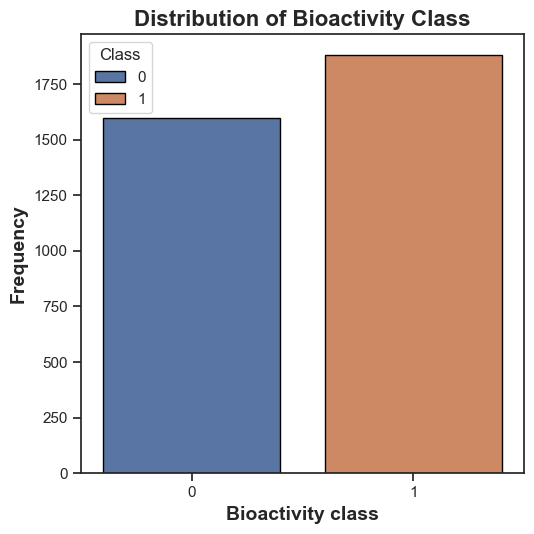

In [3]:
plt.figure(figsize=(5.5, 5.5))

# Assume there's a column named 'Target_Type' you want to use as hue
ax = sns.countplot(data=df, x='Class', hue='Class', edgecolor='black')

ax.set_xlabel('Bioactivity class', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Bioactivity Class', fontsize=16, fontweight='bold')

plt.legend(title='Class')
plt.tight_layout()
plt.savefig('plots/plot_bioactivity_class.png', dpi=600)
plt.show()

### **Lipinski descriptors**

In [4]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski

# Function to standardize SMILES and compute Lipinski descriptors
def process_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid SMILES

    # Optionally: Kekulize, sanitize, or canonicalize
    Chem.SanitizeMol(mol)

    # Lipinski descriptors
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    rot_bonds = Lipinski.NumRotatableBonds(mol)
    tpsa = Descriptors.TPSA(mol)
    return [mw, logp, hbd, hba, rot_bonds, tpsa]

# Apply to your filtered dataframe
lipinski_data = df['standardized_smiles'].apply(process_smiles)

# Drop rows with invalid SMILES
valid_idx = lipinski_data.notnull()
df = df[valid_idx].reset_index(drop=True)
lipinski_df = pd.DataFrame(lipinski_data[valid_idx].tolist(),
                           columns=["MW", "LogP", "HBD", "HBA", "RotBonds", "TPSA"])

# Merge descriptors with class labels
df_lipinski = pd.concat([df[['molecule_chembl_id', 'standardized_smiles', 'Class', 'pIC50']], lipinski_df], axis=1)

# Display
df_lipinski.head()

,molecule_chembl_id,standardized_smiles,Class,pIC50,MW,LogP,HBD,HBA,RotBonds,TPSA
0,CHEMBL350093,N#CCCN1CC(=O)OC(c2ccc(OCc3ccccc3)cc2)=N1,1,7.744727,335.363,2.69968,0,6,6,74.92
1,CHEMBL161907,O=c1c(=O)c2ccc(OCCCC(F)(F)F)cc2c1=O,1,8.045757,286.205,1.51730,0,4,4,60.44
2,CHEMBL17079,N#CCCn1nc(-c2ccc(OCc3ccccc3)cc2)oc1=S,1,8.356547,337.404,4.36527,0,6,6,63.98
3,CHEMBL434261,N#CCCn1nnc(-c2ccc(OCc3ccccc3)cc2)n1,1,8.698970,305.341,2.83278,0,6,6,76.62
4,CHEMBL17092,N#CCCn1nc(-c2ccc(OCc3ccccc3)cc2)oc1=O,1,8.657577,321.336,2.99598,0,6,6,81.05


In [6]:
df_lipinski.to_csv("data/02_mao_a_bioactivity_data_lipinski.csv", index=None)

**MW vs LogP distribution**

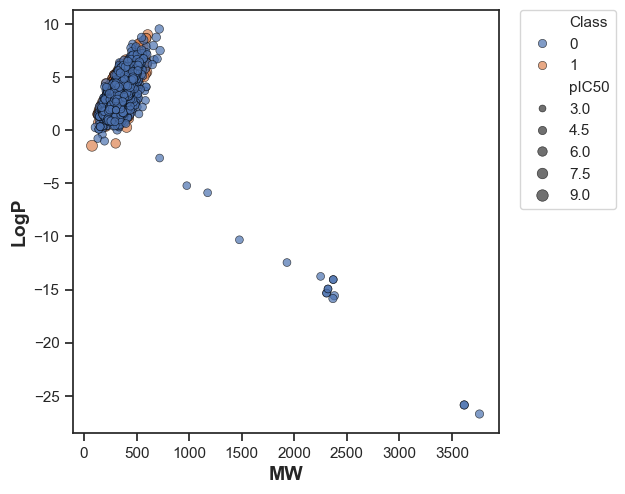

In [7]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_lipinski, hue='Class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plots/plot_MW_vs_LogP.png', dpi=600)

**Mann-Whitney test**

In [8]:
def mannwhitney(descriptor, verbose=False):
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'Class']
  df = df_lipinski[selection]
  active = df[df['Class'] == 1]
  active = active[descriptor]

  selection = [descriptor, 'Class']
  df = df_lipinski[selection]
  inactive = df[df['Class'] == 0]
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

**Boxplot of pIC50**

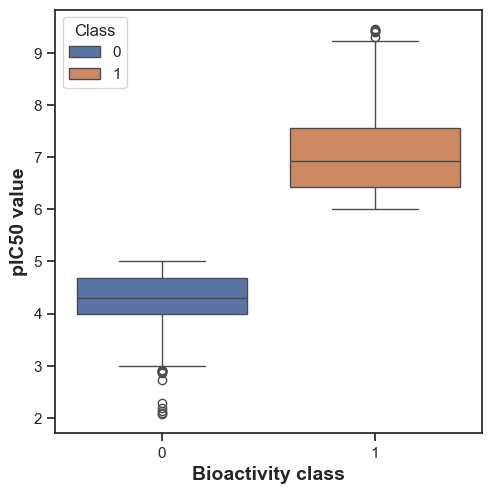

In [9]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'pIC50', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_pIc50.png', dpi=600)

In [10]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3002642.0,0.0,0.05,Different distribution (reject H0)


**Boxplot of MW**

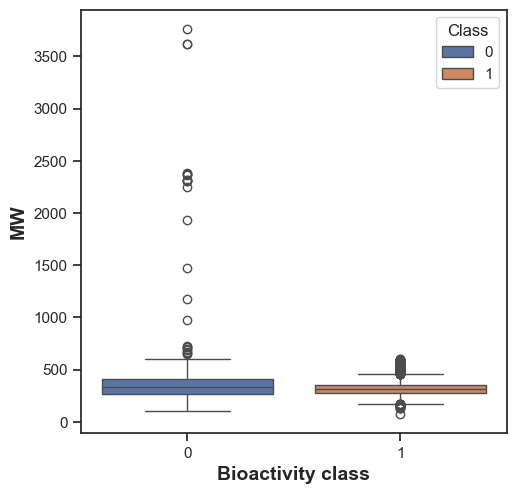

In [11]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'MW', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_MW.png', dpi=600)

In [12]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1300757.0,1.055650e-11,0.05,Different distribution (reject H0)


**Boxplot of LogP**

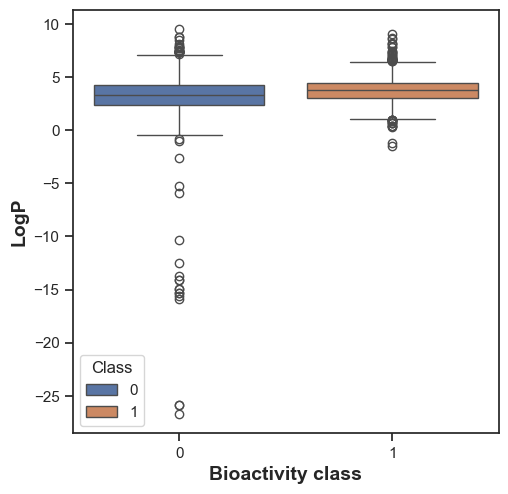

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'LogP', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_LogP.png', dpi=600)

In [14]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1783193.0,1.237257e-21,0.05,Different distribution (reject H0)


**Boxplot of HBD**

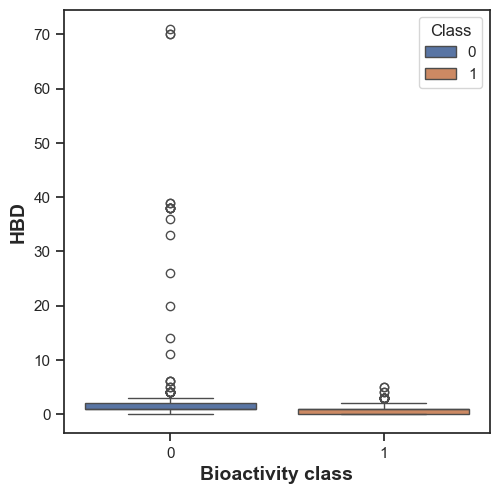

In [15]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'HBD', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('HBD', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_HBD.png', dpi=600)

In [16]:
mannwhitney('HBD')

,Descriptor,Statistics,p,alpha,Interpretation
0,HBD,1024153.0,9.754688e-68,0.05,Different distribution (reject H0)


**Boxplot of HBA**

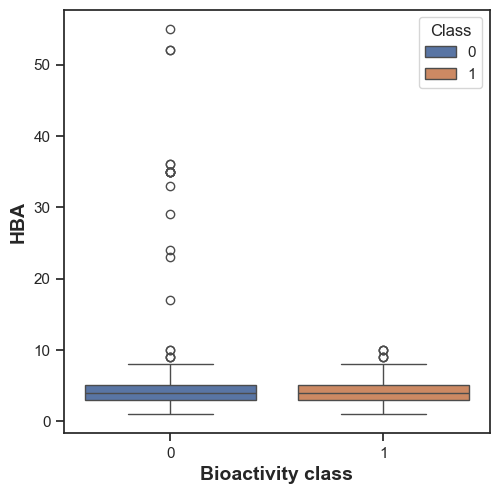

In [17]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'Class', y = 'HBA', data = df_lipinski, hue='Class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('HBA', fontsize=14, fontweight='bold')

plt.savefig('plots/plot_HBA.png', dpi=600)

In [18]:
mannwhitney('HBA')

,Descriptor,Statistics,p,alpha,Interpretation
0,HBA,1311009.0,4.997321e-11,0.05,Different distribution (reject H0)
